# Multiscale PV Recycling MILP_Arizona Case study

## Problem Statement

The following case study considers one type of solar PV panel (crystalline silicon, c-Si) that is to be recycled into separate components. The goal is to maximize economic profit obtained from the recycling process.

Data source: https://www.sciencedirect.com/science/article/pii/S0927024822000162

Assumptions
- The processes used are plot-scale or lab-scale (see data source)
- In Arizona case study, the solar installmnt companies are utilized as collection centers (ADT, Sun Power and Independent Solar)
- Manufacturer of solar panels (Meyer Burger) is buying the matrials with higher price and higher purity 
- Glass and Al collection centers are placed in Tempe, Arizona. The remaining distances between centers are based on the locations in Arizona. 

Module imports

In [23]:
import sys
sys.path.append('src')

In [24]:
import pandas 
import numpy

from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.result import Result 
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import product
from energiapy.model.constraints.integer_cuts import constraint_block_integer_cut

## Define Temporal Scale

Define temporal scales at different levels:
- 0 is annual, with 1 discretization
- 1 is daily, with 365 discretization

In [25]:
scales = TemporalScale(discretization_list=[1, 365])

## Define Resources

Define resources, which are things to be consumed, produced, stored, or sold. In this case, the feedstock is silicon PV and the products are the different major recyclable materials. We will assume that *glass* is a product in demand, whereas everything else can simply be sold.

In [26]:
SiPV_dummy = Resource(name = 'sipv_dummy', label='Silicon PV Dummy', price=50, basis = 'module', cons_max=13000)
SiPV = Resource(name = 'sipv', label='Silicon Photovoltaic', price=50, basis = 'module')
glass = Resource(name = 'glass', label='Recycled glass', revenue=100, basis = 'kg')
aluminum = Resource(name = 'al', label='Recycled aluminum', revenue=100, basis = 'kg', sell=True)
polymer = Resource(name = 'polymer', label='Recycled polymer', revenue=100, basis = 'kg', sell=True)
copper = Resource(name = 'cu', label='Recycled copper', revenue=100, basis = 'kg', sell=True)
silver = Resource(name = 'ag', label='Recycled silver', revenue=100, basis = 'kg', sell=True)
silicon = Resource(name = 'si', label='Recycled silicon', revenue=100, basis = 'kg', sell=True)

glass_dummy = Resource(name = 'glass_dummy', label='Recycled glass Dummy', revenue=100, basis = 'kg', demand=True, varying = [VaryingResource.DETERMINISTIC_DEMAND])
glass_dummy_1 = Resource(name = 'glass_dummy_1', label='Recycled glass Dummy', revenue=70, basis = 'kg', demand=True, varying = [VaryingResource.DETERMINISTIC_DEMAND])

al_dummy = Resource(name = 'al_dummy', label='Recycled aluminum Dummy', revenue=100, basis = 'kg', demand=True, varying = [VaryingResource.DETERMINISTIC_DEMAND])
al_dummy_1 = Resource(name = 'al_dummy_1', label='Recycled aluminum Dummy', revenue=70, basis = 'kg', demand=True, varying = [VaryingResource.DETERMINISTIC_DEMAND])


## Define Processes

Define processes, which are the different potential recycling processes. There are three types of process: FRELP, ASU, and Hybrid, and each process has two separate max production level to represent large-scale vs small-scale recycling.

The "collection" process is essentially a dummy process to represent PVs being shipped off from a collection center to recycling center locations. Glass_collect is the same, except for glass which is a demanded product

In [27]:
collection = Process(name = 'collection', label='dummy process', conversion = {SiPV_dummy: -1, SiPV: 1}, prod_max = 130000, capex = 0.001)
glass_collect = Process(name = 'glass_collection', label='dummy process for glass', conversion = {glass: -1, glass_dummy_1: 1}, prod_max = 10**6, capex = 0.001)
al_collect = Process(name = 'al_collection', label='dummy process for Al', conversion = {aluminum: -1, al_dummy_1: 1}, prod_max = 10**6, capex = 0.001)
Manuf_collect = Process(name = 'manuf_collection', label='dummy process for manuf', conversion = {aluminum: -1, al_dummy: 1, glass: -1, glass_dummy: 1}, prod_max = 10**6, capex = 0.0015) #need more processes, capex is a bit higher 

FRELP = Process(name = 'FRELP', label='FRELP recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.17945, silver: 0.001739}, prod_max = 1300, capex = 4, vopex = 8, block='A')
ASU = Process(name = 'ASU', label='ASU recycling', conversion = {SiPV: -1, glass: 13.73625, polymer: 2.22, aluminum: 1.5651, silicon: 0.4995, copper: 0.15355, silver: 0.001369}, prod_max = 1300, prod_min = 1, capex = 17, vopex = 9, block='A')
hybrid = Process(name = 'hybrid', label='Hybrid recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.15355, silver: 0.001369}, prod_max = 1300, capex = 3, vopex = 7, block='A')


FRELP_big = Process(name = 'FRELP_big', label='big FRELP recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.17945, silver: 0.001739}, prod_max = 13000, capex = 3, vopex = 5, block='A')
ASU_big = Process(name = 'ASU_big', label='big ASU recycling', conversion = {SiPV: -1, glass: 13.73625, polymer: 2.22, aluminum: 1.5651, silicon: 0.4995, copper: 0.15355, silver: 0.001369}, prod_max = 13000, capex = 8, vopex = 6, block='A')
hybrid_big = Process(name = 'hybrid_big', label='big Hybrid recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.15355, silver: 0.001369}, prod_max = 13000, capex = 3, vopex = 4, block='A')


## Define locations

demand_factor is the variations within demand for this particular resource at this location

In [28]:
import random 
glass_factor = pandas.DataFrame(data={'glass_dummy_1': [random.randrange(60, 100) for i in range(scales.discretization_list[1])]})
                                       
al_factor = pandas.DataFrame(data={'al_dummy_1' : [random.randrange(80,100) for i in range(scales.discretization_list[1])]})
      
manuf_factor =  pandas.DataFrame(data={'glass_dummy': [random.randrange(60, 100) for i in range(scales.discretization_list[1])], 'al_dummy' : [random.randrange(80,100) for i in range(scales.discretization_list[1])]})  

                                  

In [29]:
cc1 = Location(name='cc1', label = 'Collection Center 1', scales = scales, processes = {collection}) #ADT Solar, Arizona
cc2 = Location(name='cc2', label = 'Collection Center 2', scales = scales, processes = {collection}) #Sun Power, Arizona 
cc3 = Location(name='cc3', label = 'Collection Center 3', scales = scales, processes = {collection}) # Independentsolar, Arizona 


rc1 = Location(name='rc1', label = 'Recycling Center 1', scales = scales, processes = {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big}) #Fabtech, Arizona
rc2 = Location(name='rc2', label = 'Recycling Center 2', scales = scales, processes = {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big}) #First Solar, Arizona
rc3 = Location(name='rc3', label = 'Recycling Center 3', scales = scales, processes = {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big}) #WeRecycleSolar, Arizona


gc1 = Location(name='gc1', label = 'Recycled Glass Buyer 1', scales = scales, processes= {glass_collect}, demand_factor= {glass_dummy_1: glass_factor}, demand_scale_level= 1) #Arizona Glass company, Tempe,  Arizona
ac1 = Location(name='ac1', label = 'Recycled Aluminum Buyer 1', scales = scales, processes= {al_collect}, demand_factor= {al_dummy_1: al_factor}, demand_scale_level= 1) #Al company, Tempe, Arizona
M1 = Location(name='M1', label = 'Manufacturer 1', scales = scales, processes= {Manuf_collect}, demand_factor= {glass_dummy: manuf_factor[['glass_dummy']], al_dummy: manuf_factor[['al_dummy']]}, demand_scale_level= 1) #Meyer Burger, Arizona



In [30]:

rc3.resources

{ag, al, cu, glass, polymer, si, sipv}

## Define transportation modes

In [31]:
Trans_PV = Transport(name = 'Trans_PV', resources = {SiPV}, trans_max = 10**6, trans_cost = 0.01, label = 'Transport of PVs')
Trans_glass = Transport(name = 'Trans_glass', resources = {glass}, trans_max = 10**6, trans_cost = 0.01, label = 'Transport for recycled glass')
Trans_al = Transport(name = 'Trans_al', resources = {aluminum}, trans_max = 10**6, trans_cost = 0.01, label = 'Transport for recycled aluminum') 


#distance_matrix = [
    #[100, 100, 100, 200, 200, 200],#CC1
    #[100, 100, 100, 200, 200, 200],#CC2
    #[100, 100, 100, 200, 200, 200],#CC3
    #[0, 100, 100, 100, 100, 100],#RC1
    #[100, 0, 100, 100, 100, 100],#RC2
    #[100, 100, 0, 100, 100, 100]#RC3
#]

distance_matrix = [
    [20, 5, 15, 30, 5, 5],#CC1
    [30, 10, 10, 20, 10, 10],#CC2
    [25, 5, 10, 30, 5, 5],#CC3
    [0, 20, 30, 45, 20, 20],#RC1
    [20, 0, 10, 30, 5, 5],#RC2
    [30, 10, 0, 25, 10, 10]#RC3
    ]

#distance_matrix = [
    #[100, 100, 200, 200],CC1
    #[100, 100, 200, 200],CC2
    #[0, 100, 100, 100],R1
    #[100, 0, 100, 100] R2
    #]

transport_matrix = [
    [[Trans_PV], [Trans_PV], [Trans_PV], [], [], []],
    [[Trans_PV], [Trans_PV], [Trans_PV], [], [], []],
    [[Trans_PV], [Trans_PV], [Trans_PV], [], [], []],
    [[], [], [], [Trans_glass], [Trans_al],[Trans_glass, Trans_al]], 
    [[], [], [], [Trans_glass], [Trans_glass, Trans_al], [Trans_al]],
    [[], [], [], [Trans_glass, Trans_al], [Trans_glass], [Trans_al]]
    
]

#transport_matrix = [
    #[[Trans_PV], [Trans_PV], [], []],
    #[[Trans_PV], [Trans_PV], [], []],
    #[[], [], [Trans_glass], [Trans_al]],
    #[[], [], [Trans_glass], [Trans_al] ]
    
#]
network = Network(name = 'Network', label= 'Generic network', source_locations = [cc1, cc2, cc3, rc1, rc2, rc3], sink_locations = [rc1, rc2, rc3, M1, gc1, ac1], distance_matrix = distance_matrix, transport_matrix= transport_matrix)

In [32]:
network.source_locations

[cc1, cc2, cc3, rc1, rc2, rc3]

In [33]:
network.sink_locations

[rc1, rc2, rc3, M1, gc1, ac1]

## Define scenario. 

Glass recycling center and aluminum recycling center have some level of demand that needs fulfilling. In the Scenario object, the baseline demand is defined. In the Location object, the variations in demand per scheduling time period is defined

In [34]:
genericScenario1 = Scenario(name = 'genericScenario', network = network, scales= scales, demand={ac1: {glass_dummy_1: 0, al_dummy_1: 10000}, gc1: {glass_dummy_1: 10000, al_dummy_1: 0}, M1:{glass_dummy: 10000, al_dummy: 10000}, rc1: {glass_dummy: 0, al_dummy: 0, glass_dummy_1: 0, al_dummy_1: 0}, rc2: {glass_dummy:0, al_dummy: 0, glass_dummy_1: 0, al_dummy_1: 0}, rc3: {glass_dummy:0, al_dummy: 0, glass_dummy_1: 0, al_dummy_1: 0}}, label = 'genericScenario', network_scale_level = 0, purchase_scale_level = 1, scheduling_scale_level = 1, demand_scale_level = 1, expenditure_scale_level = 0)

In [35]:
genericScenario2 = Scenario(name = 'genericScenario2', network = network, scales= scales, label = 'genericScenario', network_scale_level = 0, purchase_scale_level = 1, scheduling_scale_level = 1, demand_scale_level = 1, expenditure_scale_level = 0)

## Optimize for cost

In [36]:
genericScenario2.revenue

{'rc2': {'si': 100,
  'polymer': 100,
  'cu': 100,
  'al': 100,
  'sipv': 0,
  'ag': 100,
  'glass': 100},
 'M1': {'glass': 100, 'glass_dummy': 100, 'al_dummy': 100, 'al': 100},
 'ac1': {'al_dummy_1': 70, 'al': 100},
 'rc1': {'si': 100,
  'polymer': 100,
  'cu': 100,
  'al': 100,
  'sipv': 0,
  'ag': 100,
  'glass': 100},
 'rc3': {'si': 100,
  'polymer': 100,
  'cu': 100,
  'al': 100,
  'sipv': 0,
  'ag': 100,
  'glass': 100},
 'cc1': {'sipv': 0, 'sipv_dummy': 0},
 'gc1': {'glass_dummy_1': 70, 'glass': 100},
 'cc2': {'sipv': 0, 'sipv_dummy': 0},
 'cc3': {'sipv': 0, 'sipv_dummy': 0}}

In [37]:
# milp_cost = formulate(scenario = genericScenario1, constraints={Constraints.INVENTORY, Constraints.COST, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK}, objective=Objective.COST)

In [38]:
# results_cost = solve(scenario = genericScenario1, instance=milp_cost, solver='gurobi', print_solversteps=True, name = 'results')

## Optimize for revenue

In [39]:
milp_revenue = formulate(scenario = genericScenario2, constraints={Constraints.INVENTORY, Constraints.COST, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK}, objective=Objective.REVENUE)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production
constraint production max
constraint production min
constraint inventory balance
constraint resource consumption
constraint resource purchase
constraint location production
constraint location discharge
constraint location consumption
constraint location purchase
constraint network production
constraint network discharge
constraint network consumption
constraint network purchase
constraint transport export
constraint transport import
constraint transport exp UB
constraint transport imp UB
constraint transport balance
constraint transport i

In [40]:
results_revenue = solve(scenario = genericScenario2, instance=milp_revenue, solver='gurobi', print_solversteps=True, name = 'results_revenue')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 616363 rows, 685367 columns and 1361800 nonzeros
Model fingerprint: 0xaff6350b
Variable types: 685169 continuous, 198 integer (198 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+06]
Found heuristic solution: objective -0.0000000
Presolve removed 616340 rows and 685325 columns
Presolve time: 0.84s
Presolved: 23 rows, 42 columns, 108 nonzeros
Variable types: 39 continuous, 3 integer (3 binary)

Root relaxation: objective 1.998152e+10, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

In [41]:
results_revenue.output['S_network']

{('polymer', 0): 31601700.000000007,
 ('cu', 0): 2431575.2500000005,
 ('al_dummy_1', 0): 0.0,
 ('al_dummy', 0): 23559067.350000005,
 ('si', 0): 7663412.249999992,
 ('glass_dummy', 0): 23559067.350000005,
 ('al', 0): 2.6557245291769505e-09,
 ('ag', 0): 22999.015,
 ('glass_dummy_1', 0): 170001345.14999998}

In [42]:
results_revenue.output['R_location']

{('rc2', 'polymer', 0): 2106780000.0000002,
 ('rc2', 'cu', 0): 158008500.0,
 ('rc2', 'al_dummy_1', 0): 0.0,
 ('rc2', 'al_dummy', 0): 0.0,
 ('rc2', 'si', 0): 510894150.0,
 ('rc2', 'glass_dummy', 0): 0.0,
 ('rc2', 'al', 0): 0.0,
 ('rc2', 'ag', 0): 1474745.9999999981,
 ('rc2', 'glass_dummy_1', 0): 0.0,
 ('M1', 'polymer', 0): 0.0,
 ('M1', 'cu', 0): 0.0,
 ('M1', 'al_dummy_1', 0): 0.0,
 ('M1', 'al_dummy', 0): 2355906735.0,
 ('M1', 'si', 0): 0.0,
 ('M1', 'glass_dummy', 0): 2355906735.0,
 ('M1', 'al', 0): 2.6557245291769505e-07,
 ('M1', 'ag', 0): 0.0,
 ('M1', 'glass_dummy_1', 0): 0.0,
 ('ac1', 'polymer', 0): 0.0,
 ('ac1', 'cu', 0): 0.0,
 ('ac1', 'al_dummy_1', 0): 0.0,
 ('ac1', 'al_dummy', 0): 0.0,
 ('ac1', 'si', 0): 0.0,
 ('ac1', 'glass_dummy', 0): 0.0,
 ('ac1', 'al', 0): 0.0,
 ('ac1', 'ag', 0): 0.0,
 ('ac1', 'glass_dummy_1', 0): 0.0,
 ('rc1', 'polymer', 0): 0.0,
 ('rc1', 'cu', 0): 0.0,
 ('rc1', 'al_dummy_1', 0): 0.0,
 ('rc1', 'al_dummy', 0): 0.0,
 ('rc1', 'si', 0): 0.0,
 ('rc1', 'glass_dummy'

## Optimize for demand

In [43]:
#milp_demand = formulate(scenario = genericScenario1, constraints={Constraints.INVENTORY, Constraints.COST, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK}, objective=Objective.MAX_DISCHARGE, objective_resource = glass_dummy)

Specify that only one process gets chosen in RC1

Integer cut constraints can also be used to indicate that we need at least/at most X many processes in this location

In [44]:
# milp_demand.constraint_block_integer_cut1 = constraint_block_integer_cut(
#     instance=milp_demand, network_scale_level=0, location=rc1, block='A', number=1, process_set=rc1.processes)

In [45]:
results_demand = solve(scenario = genericScenario, instance=milp_demand, solver='gurobi', print_solversteps=True, name = 'results')

NameError: name 'genericScenario' is not defined

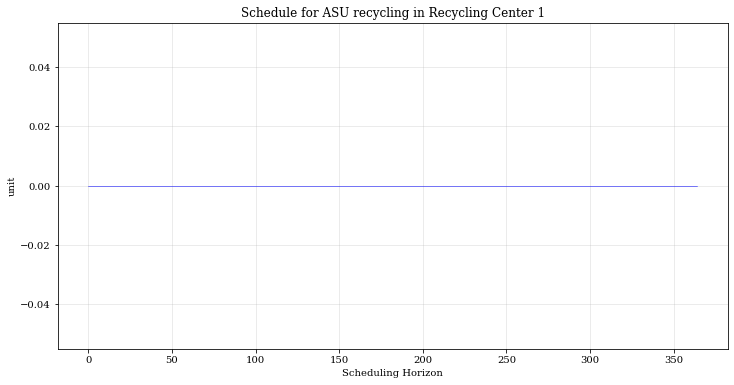

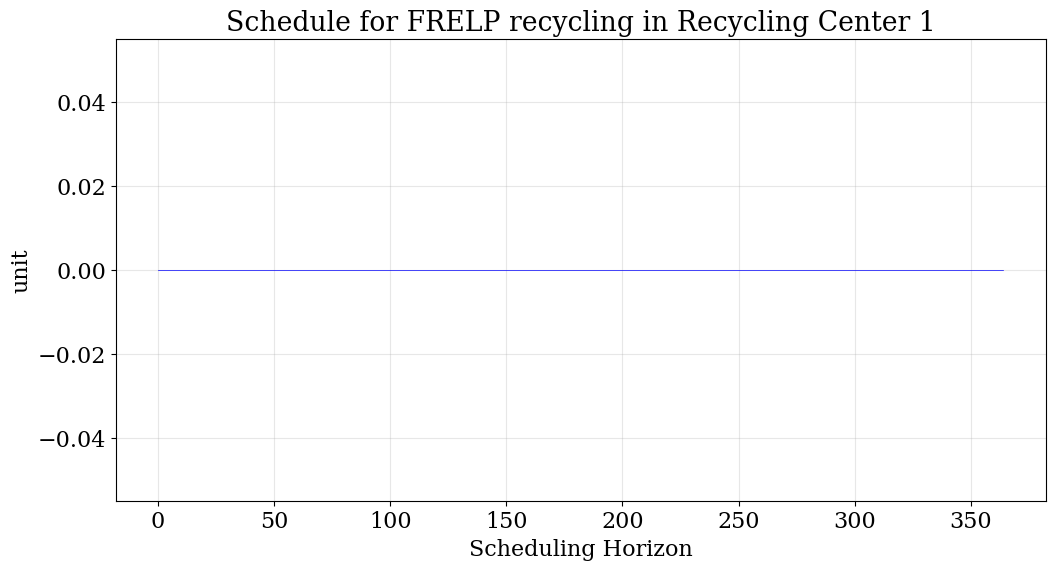

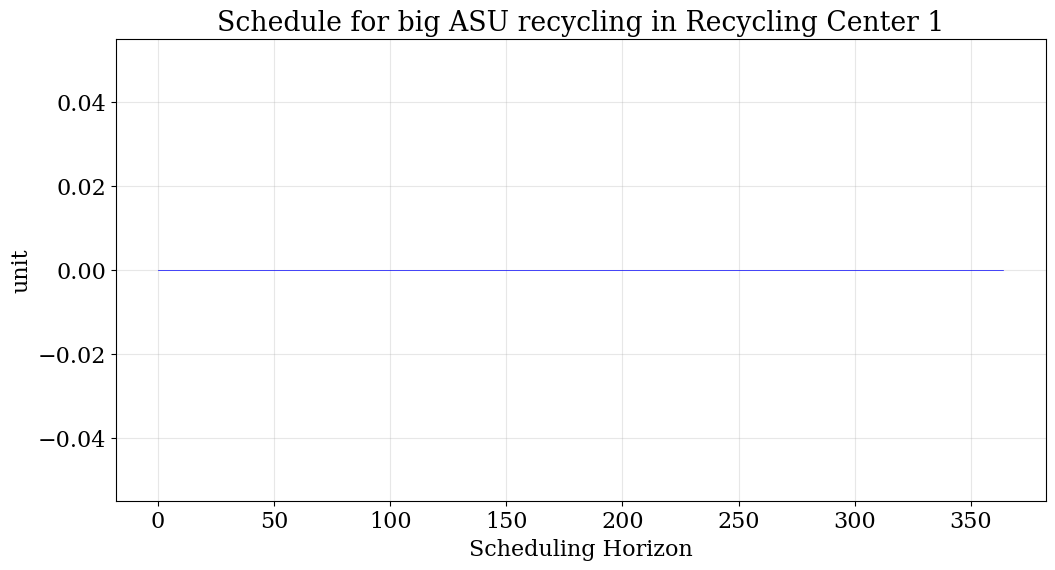

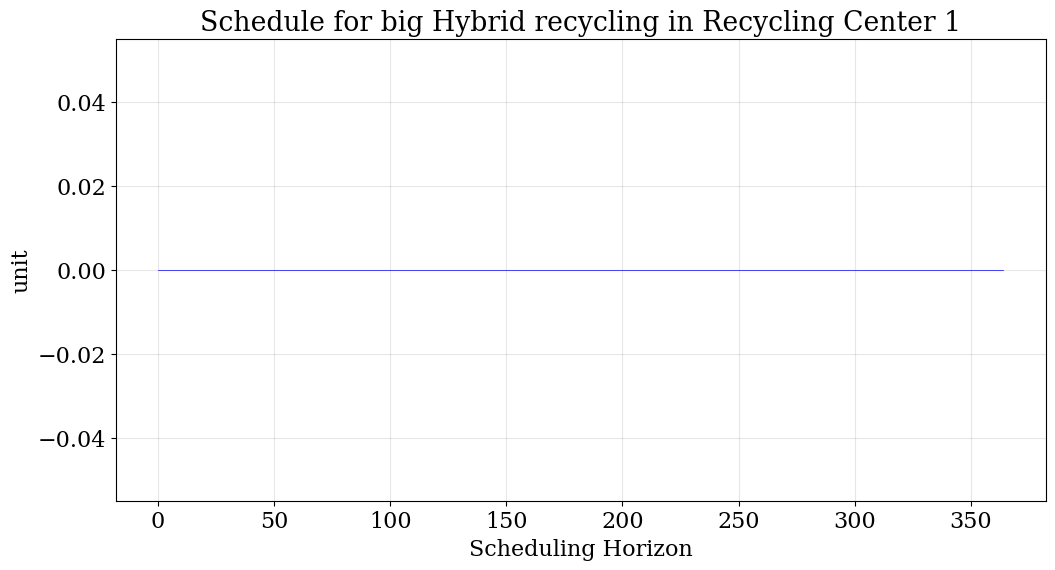

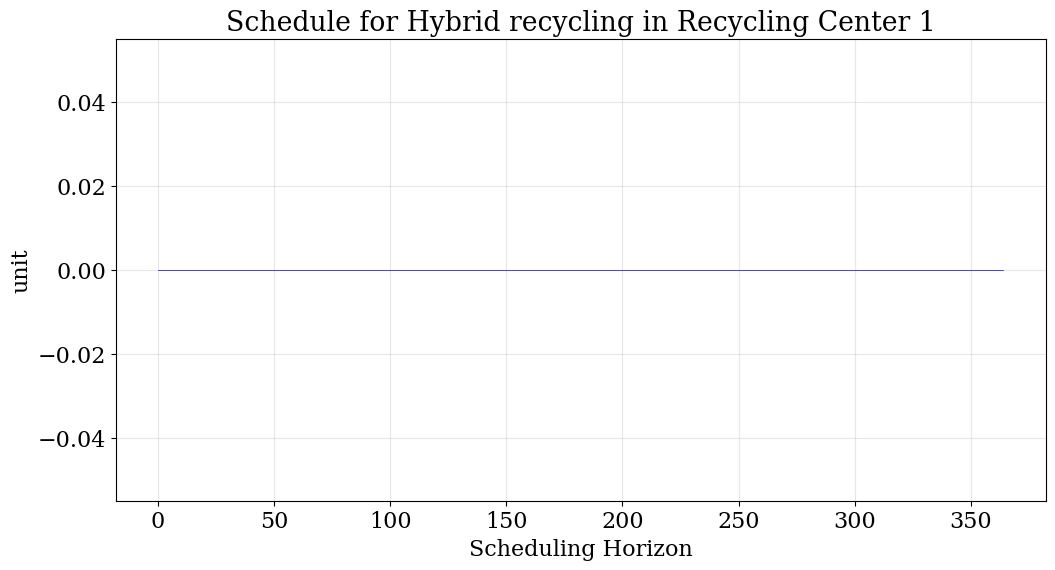

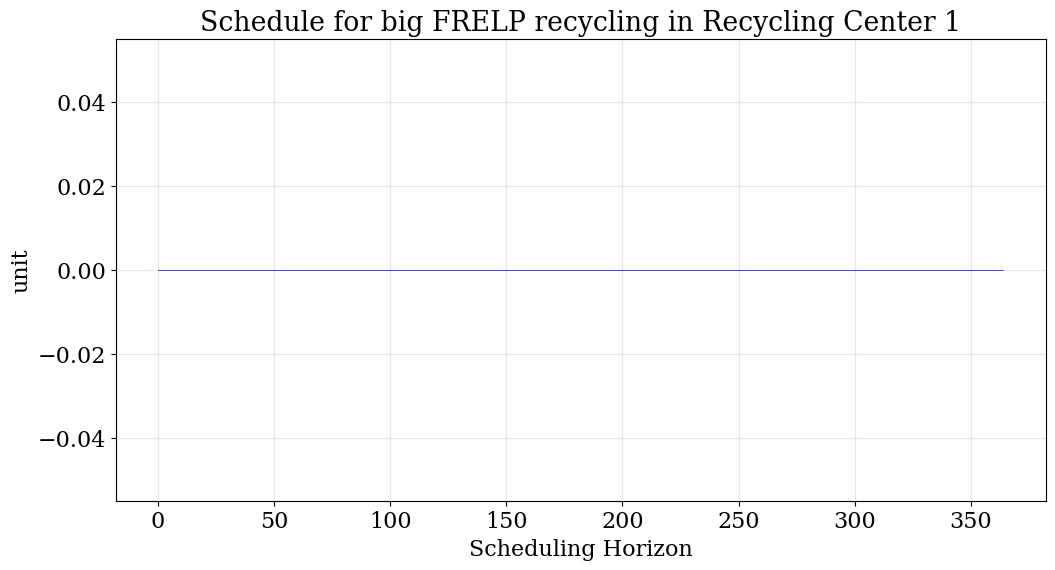

In [ ]:
for i in {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big}:
    plot_results.schedule(location = 'rc1', component = i.name, results = results_cost, y_axis = 'P')

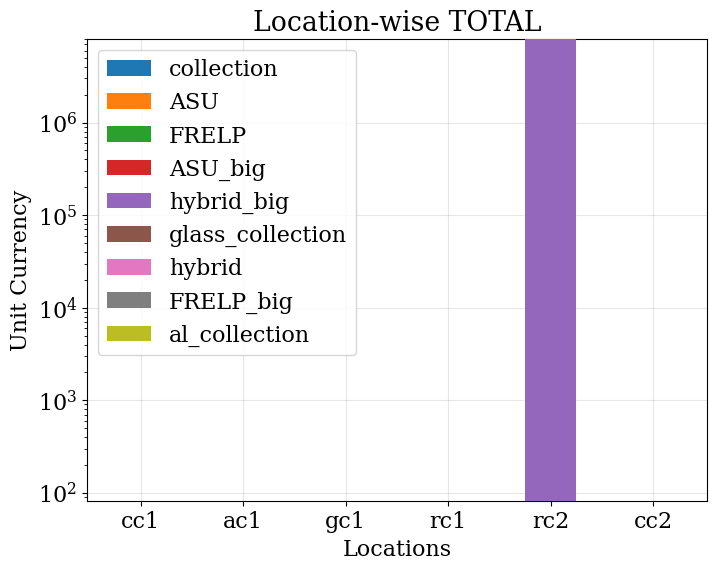

In [ ]:
plot_results.cost(results=results_cost, x=CostX.LOCATION_WISE,
                  y=CostY.TOTAL, location='rc1', fig_size=(8, 6))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


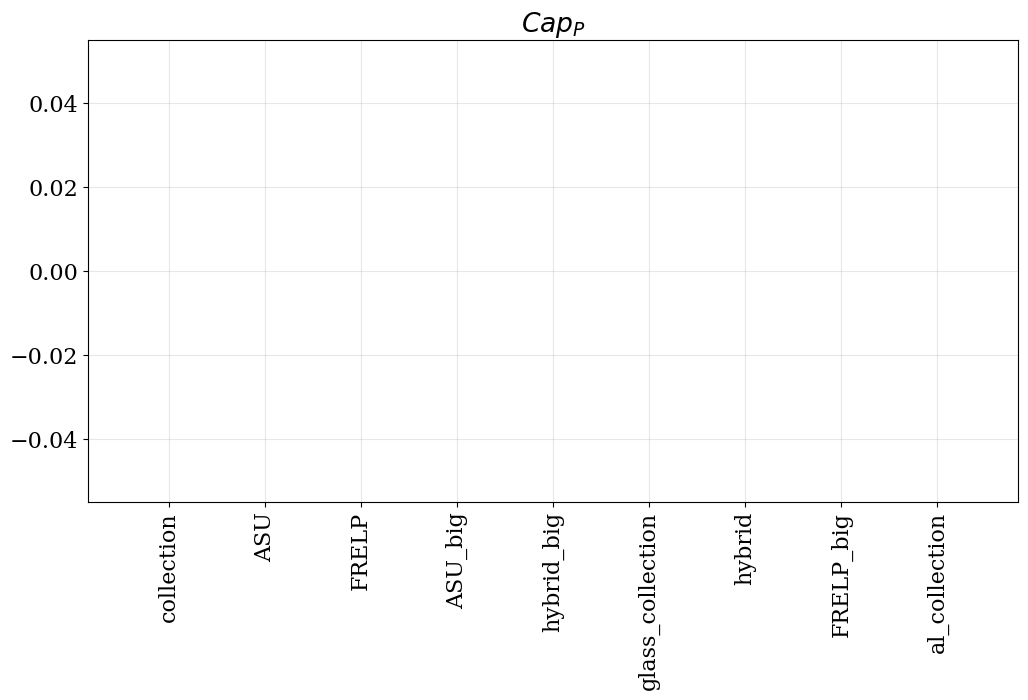

In [ ]:
plot_results.contribution(results= results_cost, location= 'rc1', y_axis= 'Cap_P')

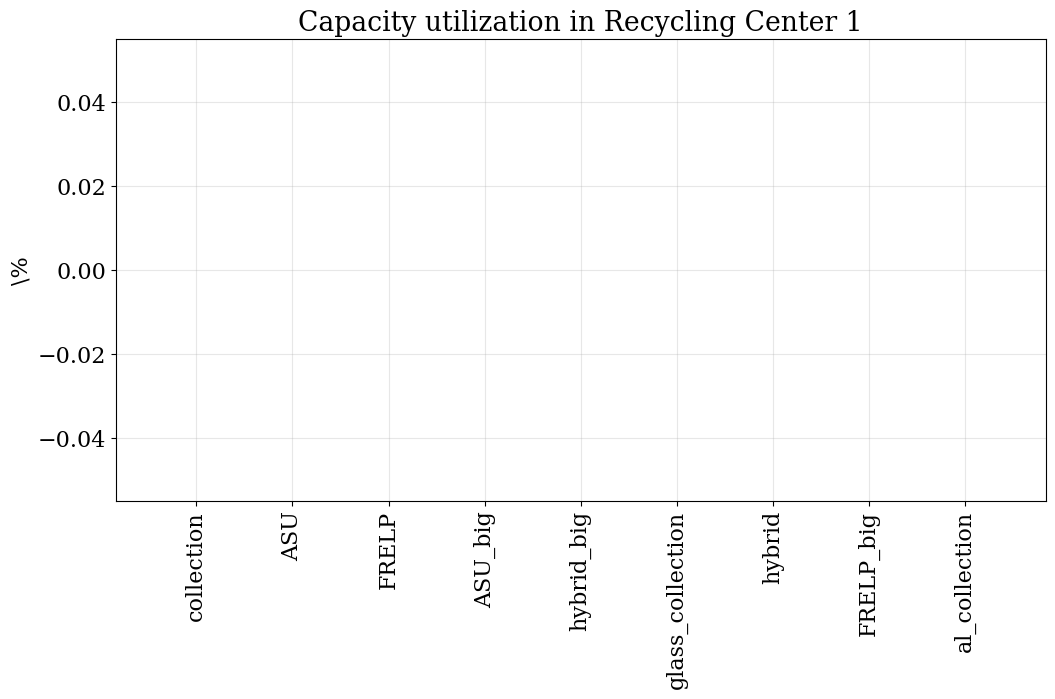

In [ ]:
plot_results.capacity_utilization(results=results_cost, location='rc1')

In [ ]:
735.4293068578783/13000

0.05657148514291371

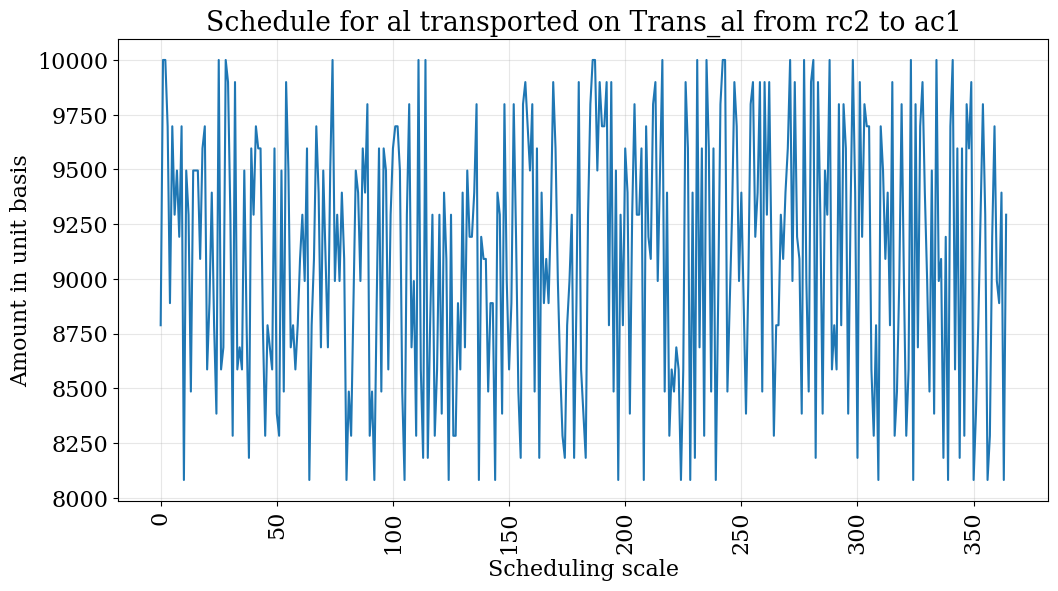

In [ ]:
plot_results.transport(results=results_cost, source= 'rc2', sink = 'ac1', resource= 'al', transport='Trans_al')